# Ethics, Fairness and Explanation in AI Coursework

Your goal in this coursework is to implement and experiment with various explainability approaches in order to better understand the behaviour of a neural model applied to the Titanic dataset. As you will have a chance to observe, the dataset reflects some of the past social conventions and biases, which also affect the trained model. Explanations can serve as very useful tools for identifying such potential issues and gaining insight into the internal reasoning of machine learning systems.

## Data Loading and Preprocessing

We start by defining some helpful utility functions for data preprocessing. You will probably not need to change this code.

In [190]:
import numpy as np
import pandas as pd
import warnings

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import RobustScaler, OneHotEncoder
from sklearn.utils import resample


class InvertibleColumnTransformer(ColumnTransformer):
    """
    This is an invertible version of a ColumnTransformer from sklearn.
    This allows us to recover the original feature values from their normalised
    versions in order to better understand the produced explanations.
    """
    def inverse_transform(self, X):
        if X.ndim == 1:
            X = np.expand_dims(X, axis=0)
        if X.shape[1] != len(self.get_feature_names_out()):
            raise ValueError(
                "X and the fitted transformer have different numbers of columns"
            )

        inverted_X_base = np.zeros((X.shape[0], self.n_features_in_))
        columns = [c for cs in self._columns for c in cs]
        inverted_X = pd.DataFrame(data=inverted_X_base, columns=columns)
        inverted_X = inverted_X.astype('object')
        for name, indices in self.output_indices_.items():
            transformer = self.named_transformers_.get(name, None)
            if transformer is None:
                continue

            selected_X = X[:, indices.start : indices.stop]
            if isinstance(transformer, OneHotEncoder):
                # Assumed only one column changing encoder at the end
                categories = transformer.inverse_transform(selected_X)
                inverted_X.loc[
                    :, columns[indices.start : indices.start + len(categories[0])]
                ] = categories
            else:
                # Assumed scaler-type transformer
                inverted_X.loc[
                    :, [columns[i] for i in range(indices.start, indices.stop)]
                ] = transformer.inverse_transform(selected_X)

        return inverted_X


def preprocess_train_data(
    df,
    scaled_features=None,
    categorical_features=None,
    scaler=RobustScaler(quantile_range=(10, 90)),
    categorical_encoder=OneHotEncoder(handle_unknown="ignore"),
):
    """
    Scales the continuous features using a RobustScaler and one-hot encodes
    the categorical features.
    """
    if scaled_features is None and categorical_features is None:
        warnings.warn("No features specified for preprocessing, using raw data.")
        scaled_features = []
        categorical_features = []
    elif scaled_features is None:
        scaled_features = [c for c in df.columns if c not in categorical_features]
    elif categorical_features is None:
        categorical_features = [c for c in df.columns if c not in scaled_features]

    preprocessor = InvertibleColumnTransformer(
        transformers=[
            ("num", scaler, scaled_features),
            ("cat", categorical_encoder, categorical_features),
        ],
        remainder="passthrough",
    )

    preprocessed_df = preprocessor.fit_transform(df)
    return preprocessed_df, preprocessor


def preprocess_test_data(df, preprocessor):
    preprocessed_df = preprocessor.transform(df)
    return preprocessed_df

Here, we define a class for the Titanic dataset, which we will be using throughout the coursework.

In [191]:
import os
import pandas as pd
import torch

from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader


class TitanicDataset(Dataset):
    """
    Loads and preprocesses the Titanic dataset.
    """
    __create_key = object()

    @classmethod
    def create_datasets(
        cls,
        label_name="survived",
        split_seed=42,
        test_size=0.2,
    ):
        train_dataset = TitanicDataset(
            cls.__create_key,
            label_name=label_name,
            split_seed=split_seed,
            test_size=test_size,
            train=True,
        )
        test_dataset = TitanicDataset(
            cls.__create_key,
            label_name=label_name,
            split_seed=split_seed,
            test_size=test_size,
            train=False,
        )
        return train_dataset, test_dataset

    def __init__(
        self,
        create_key=None,
        label_name="Survived",
        split_seed=42,
        test_size=0.2,
        train=True,
    ):
        # Ensure that the dataset is being constructed properly
        if create_key != TitanicDataset.__create_key:
            raise ValueError(
                "Illegal initialisation attempt — please use create_datasets to initialise."
            )

        try:
            data_df = pd.read_csv("titanic-dataset.csv")
        except FileNotFoundError:
            raise FileNotFoundError("Titanic data file not found.")

        # Split the dataset into train and test
        x = data_df.drop(columns=[label_name, "name", "ticket", "cabin", "embarked", "boat", "body", "home.dest"])
        # For the purposes of this coursework, we just impute the missing age and fare with a median value
        x[['age']] = x[['age']].fillna(x[['age']].median())
        x[['fare']] = x[['fare']].fillna(x[['fare']].median())
        y = data_df[label_name]
        x_train, x_test, y_train, y_test = train_test_split(
            x, y, test_size=test_size, random_state=split_seed, shuffle=True
        )
        if train:
            self.raw_data = x_train, y_train
        else:
            self.raw_data = x_test, y_test

        # Preprocess the data
        x_train_processed, preprocessor = preprocess_train_data(
            x_train, categorical_features=["sex"]
        )
        x_train = pd.DataFrame(
            x_train_processed, columns=preprocessor.get_feature_names_out()
        )
        x_test_processed = preprocess_test_data(x_test, preprocessor)
        x_test = pd.DataFrame(
            x_test_processed, columns=preprocessor.get_feature_names_out()
        )

        # Select data partition and convert to tensors
        if train:
            samples = x_train
            labels = y_train
        else:
            samples = x_test
            labels = y_test
        self.samples = torch.tensor(samples.to_numpy(), dtype=torch.float32)
        self.labels = torch.tensor(labels.to_numpy(), dtype=torch.long)
        self.features = preprocessor.get_feature_names_out()
        self.preprocessor = preprocessor

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        return self.samples[idx], self.labels[idx]

Finally, we call the code above to load and preprocess the data.

In [192]:
train_dataset, test_dataset = TitanicDataset.create_datasets(
    test_size=0.2,
    split_seed=42,
)
train_dl = DataLoader(
    dataset=train_dataset,
    batch_size=128,
    shuffle=False,
)
test_dl = DataLoader(
    dataset=test_dataset,
    batch_size=64,
    shuffle=False,
)

Note that the invertible transformer allows you to recover the original (unnormalised) feature values, as shown on the example below. You may find this helpful for understanding the produced explanations and commenting on them in your report.

In [193]:
test_dataset.preprocessor.inverse_transform(test_dataset.samples[0])

,pclass,age,sibsp,parch,fare,sex
0,3.0,35.0,0.0,0.0,7.125,male


## Exploratory Data Analysis

When faced with a new dataset, it is a good practice to perform an exploratory data analysis in order to understand the basic trends in the data. This will also allow you to put the explanations you obtain as part of this coursework into the relevant context. We will use the raw, unnormalised features for this purpose, as they are much more intuitive and human-understandable.

In [194]:
x_train, y_train = train_dataset.raw_data
x_train['survived'] = y_train
data_df = x_train

We start by displaying the feature values and labels for a few samples. The dataset contains data regarding the survival of some of the passengers involved in the [Titanic maritime disaster](https://en.wikipedia.org/wiki/Sinking_of_the_Titanic). The features contained in the data are as follows:
* `pclass`: Indicates the travelling class of the given passenger. Note that we treat this feature as numerical, as the different classes introduce a natural order.
* `sex`: Indicates the sex of the passenger.
* `age`: Provides the age of the passenger.
* `sibsp`: Denotes the total number of siblings and spouses of the given passenger also travelling on RMS Titanic.
* `parch`: Denotes the total number of parents or children of the given passenger also travelling on RMS Titanic.
* `fare`: Indicates the fare paid by the passenger for the journey.
* `survived`: The label indicating whether the patient survived the accident (1 = survived, 0 = did not survive).

There are other features included in the original dataset (such aspassenger name or point of embarkation), but we choose to ignore them for the purposes of this coursework.

In [195]:
data_df

,pclass,sex,age,sibsp,parch,fare,survived
772,3,male,17.0,0,0,7.8958,0
543,2,male,36.0,0,0,10.5000,0
289,1,female,18.0,0,2,79.6500,1
10,1,male,47.0,1,0,227.5250,0
147,1,male,28.0,0,0,42.4000,0
...,...,...,...,...,...,...,...
1095,3,female,28.0,0,0,7.6292,0
1130,3,female,18.0,0,0,7.7750,0
1294,3,male,28.5,0,0,16.1000,0
860,3,female,26.0,0,0,7.9250,1


Let us visualise the correlation between the individual columns of the data, computed using the [Pearson correlation coefficient](https://en.wikipedia.org/wiki/Pearson_correlation_coefficient). Note that we excluded the `sex` feature from this visualisation, as it is categorical.

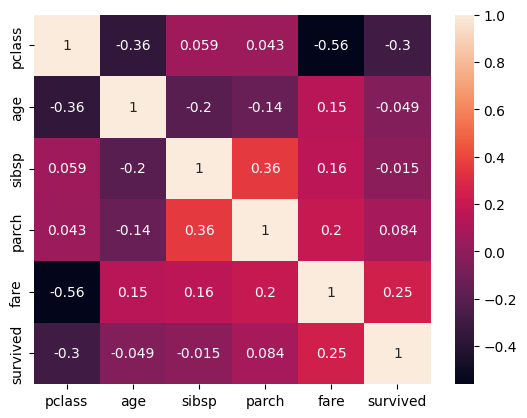

In [196]:
import matplotlib.pyplot as plt
import seaborn as sns

corr = data_df.drop(columns=["sex"]).corr()
sns.heatmap(
    corr,
    xticklabels=corr.columns.values,
    yticklabels=corr.columns.values,
    annot=True,
    fmt='.2g',
)
plt.show()

Since the previous plot does not include the categorical `sex` column, we also separately visualise its distribution, including the associated labels.

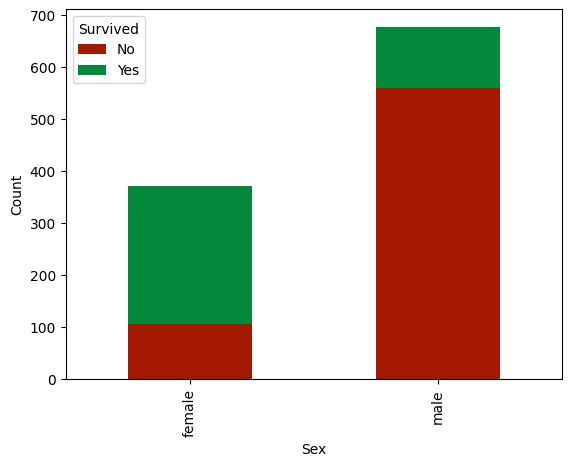

In [197]:
data_df.groupby(['sex', 'survived']).size().unstack().plot(
    kind='bar', stacked=True, color=['#a51900', '#02893b'], xlabel="Sex", ylabel="Count"
)
plt.legend(['No', 'Yes'], title="Survived")
plt.show()

**Task 1(a)**: <br />
**(i)** Considering the above visualisations, are there any trends or patterns that you can identify in the data? <br />
**(ii)** Without having access to any particular model or the associated explanations, which features would you expect to be the most and least important for a neural network trained on the dataset? How can you tell and how certain can you be of your assessment? <br />
**(iii)** Apart from inspecting the above plots, is there anything else you could do as part of the exploratory analysis that would allow you to better understand the data and the behaviour of the models trained on it? <br />
Please write your answers in a few sentences.

## Model Initialisation and Training

First, we define a global device variable to enable running this code on a GPU or a CPU, as needed.

In [198]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Here, we define several utility functions for constructing, training and evaluating neural networks.

In [199]:
import torch
import torch.nn as nn

from torcheval.metrics.functional import binary_f1_score, binary_accuracy, binary_auroc
from tqdm.auto import tqdm

def construct_nn(nn_dims, activation_fun):
    """
    Constructs a neural network with the specified architecture.
    """
    layers = []
    for i in range(1, len(nn_dims)):
        in_dim, out_dim = nn_dims[i-1], nn_dims[i]
        layers.append(nn.Linear(in_dim, out_dim))
        layers.append(activation_fun())
    # Remove the last activation layer and add Sigmoid instead
    layers = layers[:-1]
    layers.append(nn.Sigmoid())
    
    return nn.Sequential(*layers).to(DEVICE)

def train_nn(model, train_dl, num_epochs=100):
    """
    Trains a neural network using the data from the provided data loader.
    """
    loss_fun = nn.BCELoss()
    opt = torch.optim.AdamW(model.parameters(), lr=0.005)
    model.train()
    
    losses = []
    for epoch in tqdm(range(num_epochs), leave=False):
        total_loss = 0
        for i, (x, y) in list(enumerate(train_dl)):
            x, y = x.to(DEVICE), y.to(DEVICE)
            opt.zero_grad()
            out = model(x)
            loss = loss_fun(out.squeeze(-1), y.float())
            total_loss += loss.item()
            loss.backward()
            opt.step()
            opt.zero_grad()
        losses.append(total_loss)

def eval_nn(model, test_dataset):
    """
    Evaluates binary classification performance of a model on the given
    test dataset.
    """
    model.eval()

    loss_fun = nn.BCELoss()
    predictions = model(test_dataset.samples.to(DEVICE))
    labels = test_dataset.labels.unsqueeze(-1).to(DEVICE)
    loss = loss_fun(predictions, labels.float()).item()

    predictions = predictions.squeeze(-1).detach()
    labels = labels.squeeze(-1).detach()
    f1 = binary_f1_score(predictions, labels).item()
    accuracy = binary_accuracy(predictions, labels).item()
    auc = binary_auroc(predictions, labels).item()

    return loss, f1, accuracy, auc

In this cell, we initialise and train the neural model that we will be explaining in this coursework. For a real-world application, you would typically wish to perform a full hyperparameter search in order to identify the most effective model architecture. However, achieving a maximum performance is not the objective of this coursework, so we just pre-define a model that performs reasonably well on the given task.

In [201]:
def print_metric(name, value):
    print(f"{name}: {'{:.2f}'.format(round(value, 2))}")

torch.manual_seed(42)
np.random.seed(42)
model = construct_nn([7, 256, 256, 1], nn.ReLU).to(DEVICE)

print("———————[ Model training ]———————")
train_nn(model, train_dl, num_epochs=1000)
print("Training completed!")
print()

print("———————[ Evaluation ]———————")
test_loss, f1, accuracy, auc = eval_nn(model, test_dataset)
print_metric("F1 score", f1)
print_metric("Accuracy", accuracy)
print_metric("AUC", auc)

———————[ Model training ]———————


  0%|          | 0/1000 [00:00<?, ?it/s]

Training completed!

———————[ Evaluation ]———————
F1 score: 0.75
Accuracy: 0.80
AUC: 0.82


## Feature Attributions

In this section of the coursework, you will implement SHAP as introduced in the lectures and conduct additional experiments with various feature attribution methods.

### SHAP Implementation

**Task 2(a)(i)**: As a first step in implementing SHAP, define a `compute_coefficient` function to compute the SHAP coalition coefficient/weight as specified by the formula from the lectures:

$$g_{SHAP}(\mathcal{M},\mathbf{x},i) = \sum_{\mathbf{z} \subseteq \mathbf{x}}{\frac{|\mathbf{z}|!(n - |\mathbf{z}| - 1)! }{n!} \mathcal{M}( \mathbf{z}) - \mathcal{M}(\mathbf{z}_{-i})} \nonumber$$

In [ ]:
import math

def compute_coefficient(num_in_coalition, total_features):
    """
    Computes the SHAP coefficient for a coalition.

    Parameters:
        num_in_coalition (int): The number of features in the given coalition
        total_features (int): The total number of considered features

    Returns:
        coefficient (float): The SHAP weight for the given coalition
    """
    return (math.factorial(num_in_coalition) * math.factorial(total_features-num_in_coalition-1))/(math.factorial(total_features))

**Task 2(a)(ii)**: Next, define a function `generate_coalitions`, which will return the list representing all the possible coalitions for a possible feature.

Hint #1: You may find it helpful to use [itertools](https://docs.python.org/3/library/itertools.html) and [Python generators](https://wiki.python.org/moin/Generators) for implementing this function.

Hint #2: Passing a full list of feature IDs is not strictly necessary here, but you will find this list helpful for implementing other functions, so we also recommend taking it as a parameter here. As an example, for the Titanic dataset, this list could look like `[0, 1, 2, 3, 4, 5, 5]` (note the repeated `5` for the one-hot-encoded `sex` feature).

In [ ]:
import itertools

def generate_coalitions(feature_ids, target_feature_id):
    """
    Generates the possible feature coalitions for the purpose of computing the Shapley value
    for the target feature.

    Parameters:
        feature_ids (list): A list with feature IDs from 0 to N (where N is
            the total number of features) identifying the used features. Distinct
            columns for one-hot-encoded features should be assigned the same
            numerical ID.
        target_feature_id (int): The ID of the removed feature for which the coalitions
            should be generated.

    Retruns:
        coalitions (list): A nested list structure of coalitions in the form:
            [(set(coalition 1 in features set), set(coalition 1 out features set)), ...].
            Note that feature_id should not appear in either of the in/out lists.
    """
    remaining_features = [f for f in feature_ids if f != target_feature_id]
    coalitions = []
    for size in range(len(remaining_features)+1):
        for subset in itertools.combinations(remaining_features, size):
            included = set(subset)
            excluded = set(remaining_features) - included
            coalitions.append((included, excluded))
    return coalitions

**Task 2(a)(iii)**: Next, implement a function `delete_features` that deletes the specified features from the given input tensor `x`. In contrast with the setting in the SHAP tutorial, the majority of features considered in this coursework are non-binary, which makes the deletion of features slightly more challenging. The general procedure for performing the deletion can be described as follows:
1. For each sample in `x` and each deleted feature, randomly sample the value of the deleted feature from another data point in the background dataset
2. If the sampled value is identical to the current value of the deleted feature, continue sampling new values until finding one that differs. This ensures that feature deletion actually changes the values of categorical variables or variables with few possible values.
3. Replace the value of the deleted feature in the currently considered sample with the newly sampled value

Hint #1: Boolean tensor masks "selecting" certain features can be very helpful here.

Hint #2: Make sure not to overwrite values in the original `x` when deleting features. Instead, the function should return a new tensor.

In [ ]:
def delete_features(x, background_dataset, feature_ids, deleted_feature_ids):
    """
    Deletes the specified features from inputs x using the background dataset.

    Parameters:
        x (Tensor): A tensor of inputs with the shape (batch_size, num_features).
        background_dataset (Tensor): A tensor of background data samples with the same shape as x.
        feature_ids (list): A list with feature IDs, same as in generate_coalitions.
        deleted_feature_ids (set): A set with feature IDs to be deleted from x.

    Returns:
        x_deleted (tensor): A new tensor of inputs with the specified features deleted.
    """
    # Make the sampling deterministic
    torch.manual_seed(42)
    np.random.seed(42)
    
    # First create x_deleted as a copy of x
    x_deleted = x.clone()

    for deleted_id in deleted_feature_ids:

        # Loop through each row in x_deleted, delete (replace) each feature specified in deleted_feature_ids
        for i in range(x.shape[0]):
            original_value = x[i, deleted_id]

            # Randomly sample this value from background_dataset until it's different
            sampled_value = original_value
            while sampled_value == original_value:
                background_column = background_dataset[:,deleted_id]
                sampled_value = background_column[torch.randint(0, len(background_column), (1,))].item()
                
            x_deleted[i, deleted_id] = sampled_value

    return x_deleted


**Task 2(a)(iv)**: Finally, put everything together in the `shap_attribute` function, which will compute the SHAP attributions for the given input and model. Note that the function also takes in a `target_idx` specifying for which output neuron the explanations should be computed. This is not strictly necessary for the Titanic model, which only has a single Sigmoid output, but will be needed once you start working with a more complex model.

In [ ]:
def shap_attribute(model, x, background_dataset, feature_ids, target_idx=0):
    """
    Computes the SHAP attributions for the given input and model.

    Parameters:
        model (Object): A PyTorch model for which the attributions should be computed.
        x (Tensor): Inputs for which the explanations should be computed, in shape (batch_size, num_features).
        background_dataset (Tensor): A tensor of background data samples with the same shape as x.
        feature_ids (list): A list with feature IDs, same as in generate_coalitions.
        target_idx (int): The ID of the target neuron for which to compute an explanation
            (useful for classification tasks with multiple labels where it should correspond

    Returns:
        attributions (Tensor): A tensor of SHAP attributions, with the same shape as the input
    """
    # Initialise attributions as a tentor with same shape as x
    attributions = torch.empty(x.shape, dtype=torch.float32)
    
    # Convert target_idx to tensor if it's not already
    if isinstance(target_idx, int):
        target_idx = torch.full((x.shape[0],), target_idx)

    # Loop through each row
    for i in range(x.shape[0]):
        
        current_target = target_idx[i] if torch.is_tensor(target_idx) else target_idx

        # Loop through each feature in the current sample (i.e. row of x), calculate shapley score
        sample_x = x[i].unsqueeze(0)
        for j in range(x.shape[1]):
            
            g_shap = 0
            coalitions = generate_coalitions(feature_ids, j)
            for coalition in coalitions:
                included_features, excluded_features = coalition

                # Construct z and z-i
                sample_with_coalition = delete_features(sample_x, background_dataset, feature_ids, excluded_features)
                sample_deleted_feature = delete_features(sample_with_coalition, background_dataset, feature_ids, {j})
                
                # Calculate M(z) and M(z-i)
                pred_with = model(sample_with_coalition)[:, current_target]
                pred_without = model(sample_deleted_feature)[:, current_target]
                
                # Calculate g_shap
                shap_weight = compute_coefficient(len(included_features), len(feature_ids))
                g_shap += shap_weight * (pred_with - pred_without)

            attributions[i,j] = g_shap

    return attributions

### Additional Explanation Methods

Apart from SHAP, which you just implemented, you will also be experimenting with two more feature attribution methods implemented in the [Captum](https://captum.ai/) library — [Shapley Value Sampling](https://captum.ai/api/shapley_value_sampling.html) and [DeepLIFT](https://captum.ai/api/deep_lift.html). Shapley Value Sampling is a more computationally tractable approximation of SHAP and computes the scores by randomly sampling a fixed number of coalitions instead of considering all of them. Meanwhile, DeepLIFT is a fast gradient-based attribution method specifically designed for neural models. If you are interested, you can learn more about DeepLIFT in [its original paper](https://arxiv.org/abs/1704.02685).

To get you started, we provide an example of how to use the Captum library to generate Shapley Value Sampling attributions for the first sample from the Titanic test set (note that the library also allows you to compute attributions for a batch of inputs):

In [ ]:
from captum.attr import ShapleyValueSampling

# Note that this is similar to feature_ids from the implementation above,
# but the shape and the data type are different
feature_mask = torch.tensor([[0, 1, 2, 3, 4, 5, 5]]).to(DEVICE)
svs = ShapleyValueSampling(model)
attributions = svs.attribute(test_dataset.samples[[0]].to(DEVICE), target=0, feature_mask=feature_mask)
attributions

tensor([[ 0.0000,  0.1617,  0.0000,  0.0000,  0.2395, -0.4373, -0.4373]])

Notice that, in contrast with the SHAP implementation above, we did not need to pass in the background dataset. This is because Captum takes a slightly different approach to deleting features and instead replaces them with a pre-specified baseline value (see the `baselines` parameter description in the [documentation](https://captum.ai/api/shapley_value_sampling.html)). For the purposes of this coursework, it is fine to use the default (zero) baseline for both Shapley Value Sampling and DeepLIFT.

### Feature Attribution Experiments

In this section, you will conduct several experiments associated with feature attribution methods.

**Task 2(b)**: Using your implementation of SHAP and Captum implementations of Shapley Value Sampling and DeepLIFT, compute feature attributions for 10 randomly selected instances from the Titanic test set. Then answer the following questions: <br />
**(i)** Which features generally seem to be the most important and least important for the explained model according to each of the explanations? <br />
**(ii)** Are there any substantial differences between the different attribution methods? What might be the possible reasons for the different methods returning different attribution scores? <br />
**(iii)** Do the attribution scores match your expectations for the most/least important features from task 1(a)(ii)? What might be the reasons for a user's expected explanations differing from the computed attribution explanations? <br />
**(iv)** Considering the insights gained from the exploratory data analysis and the feature attribution explanations, as well as the definitions of the explanations themselves, what are the potential advantages/disadvantages of each of these methods when trying to understand the behaviour of a model on a particular dataset? <br />

In [ ]:
# Set the format for showing result to keep clean
torch.set_printoptions(sci_mode=False,linewidth=100)

In [ ]:
from captum.attr import ShapleyValueSampling, DeepLift

# Randomly select 10 instances from Titanic test set
test_samples = test_dataset.samples
random_indices = torch.randperm(len(test_samples))[:10]
random_sample_of_10 = test_samples[random_indices]


# SHAP implementation from above
background_indices = torch.randperm(len(test_dataset.samples))[:10]  
background_dataset = test_dataset.samples[background_indices]  # Shape: (10, num_features)
attributions_SHAP = shap_attribute(model, random_sample_of_10, background_dataset, feature_ids=[0, 1, 2, 3, 4, 5, 5], target_idx=0)
print('Scores by shap_attribute function from above:')
print(attributions_SHAP)

feature_importance_SHAP = torch.mean(torch.abs(attributions_SHAP), dim=0)
sorted_features_SHAP = sorted(enumerate(feature_importance_SHAP.tolist()), key=lambda x: x[1], reverse=True)
print("\nSorted Feature Importance:")
for i, score in sorted_features_SHAP:
    print(f"Feature {i}: {score:.4f}")


# Shapley Value Sampling
feature_mask = torch.tensor([[0, 1, 2, 3, 4, 5, 5]]).to(DEVICE)
svs = ShapleyValueSampling(model)
attributions_SVS = svs.attribute(test_dataset.samples[random_indices].to(DEVICE), target=0, feature_mask=feature_mask)
print('Scores by Shapley Value Sampling:')
print(attributions_SVS)

feature_importance_SVS = torch.mean(torch.abs(attributions_SVS), dim=0)
sorted_features_SVS = sorted(enumerate(feature_importance_SVS.tolist()), key=lambda x: x[1], reverse=True)
print("\nSorted Feature Importance:")
for i, score in sorted_features_SVS:
    print(f"Feature {i}: {score:.4f}")


# DeepLIFT
deeplift = DeepLift(model)
attributions_deeplift = deeplift.attribute(test_dataset.samples[random_indices].to(DEVICE), target=0)
print('Scores by DeepLIFT:')
print(attributions_deeplift)

feature_importance_deeplift = torch.mean(torch.abs(attributions_deeplift), dim=0)
sorted_features_deeplift = sorted(enumerate(feature_importance_deeplift.tolist()), key=lambda x: x[1], reverse=True)
print("\nSorted Feature Importance:")
for i, score in sorted_features_deeplift:
    print(f"Feature {i}: {score:.4f}")

# show feature names for report
print("Feature names after preprocessing:", train_dataset.features)

Scores by shap_attribute function from above:
tensor([[    -0.0621,     -0.0525,      0.1464,     -0.0003,     -0.0097,     -0.0490,     -0.8823],
        [     0.1720,      0.1027,      0.0016,     -0.2442,     -0.0380,      0.0300,      0.7109],
        [    -0.0818,      0.0419,      0.1645,     -0.0246,     -0.0107,     -0.0667,     -1.1506],
        [     0.0235,      0.0797,     -0.0716,      0.1694,     -0.1619,     -0.0217,     -0.2038],
        [     0.1013,      0.0281,      0.1491,      0.0002,     -0.0055,     -0.0977,     -1.1359],
        [    -0.0724,     -0.0529,      0.1502,     -0.0444,     -0.0126,     -0.0416,     -1.3554],
        [     0.0930,      0.0198,     -0.0129,      0.0291,      0.0576,      0.1074,      1.5163],
        [     0.1065,      0.0379,      0.1697,     -0.0753,      0.0053,     -0.0725,     -1.1343],
        [     0.1810,      0.0699,      0.0422,     -0.0311,     -0.0727,     -0.1917,     -1.4688],
        [     0.1803,     -0.0896,      0.065

d:\MScAI\ethics\explainability-cw\xaivenv\Lib\site-packages\captum\_utils\gradient.py:57: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  warnings.warn(
d:\MScAI\ethics\explainability-cw\xaivenv\Lib\site-packages\captum\attr\_core\deep_lift.py:304: UserWarning: Setting forward, backward hooks and attributes on non-linear
               activations. The hooks and attributes will be removed
            after the attribution is finished
  warnings.warn(


**Task 2(c)**: Perform a quantitative evaluation of the different attribution methods by computing their mean [infidelity](https://captum.ai/api/metrics.html) on the full Titanic dataset. On a high level, infidelity aims to estimate how closely the generated explanations correspond with the behaviour of the explained model by slightly perturbing the inputs and measuring how much the observed change in the model output differs from the change predicted by the corresponding feature attributions (when considering a linear model with the same weights as the feature attribution scores). If you are interested, you can find more details regarding this metric in [the original paper](https://arxiv.org/abs/1901.09392). A downside of the infidelity metric is that one needs to define a suitable perturbation function for changing the model inputs, which can significantly affect the results. In this coursework, we provide you with a perturbation function adding Gaussian noise to continuous features and performing resampling for categorical features. In your evaluation, you should experiment with two or three different standard deviations and categorical resampling probabilities. Once you are done, add a table summarising the results to your report and comment on the findings. Note that lower infidelity scores are better.

Note: You should use `normalize=True` and `n_perturb_samples=10` as parameters to the Captum's infidelity function and set the same Torch and NumPy seeds before computing the infidelity for each method (so that all methods are evaluated using the same sample perturbations).

In [ ]:
from captum.metrics import infidelity, infidelity_perturb_func_decorator

def perturb_func_constructor(noise_scale, cat_resample_proba, background_dataset, feature_ids, n_perturb_samples=10):
    """
    You can call this function to construct a perturbation function with the desired parameters,
    which can then be provided as the perturb_func parameter to the infidelity metric implementation
    from Captum.

     Parameters:
        noise_scale (float): A standard deviation of the Gaussian noise added to the continuous features.
        cat_resample_proba (float): Probability of resampling a categorical feature.
        background_dataset (Tensor): A tensor of background data samples with the shape (num_samples, num_features).
        feature_ids (list): A list with feature IDs, same as in generate_coalitions.
        n_perturb_samples (int): The number of perturbed samples for each input. Should match the value
            of the corresponding parameter to the Captum's infidelity function.

    Returns:
        perturb_func (function): A perturbation function compatible with Captum
    """
    @infidelity_perturb_func_decorator(True)
    def perturb_func(inputs):        
        # Construct masks for noise and resampling categorical variables
        noise_mask = torch.ones(1, inputs.size(1)).to(DEVICE)
        # We assume that categorical features are one-hot-encoded
        i = 0
        current_span_start = 0
        categorical_spans = []
        while i < len(feature_ids) - 1:    
            if feature_ids[i] != feature_ids[i + 1] and current_span_start != i:
                categorical_spans.append((current_span_start, i))
                current_span_start = i + 1
            elif feature_ids[i] != feature_ids[i + 1]:
                current_span_start = i + 1
            elif feature_ids[i] == feature_ids[i + 1] and i == len(feature_ids) - 2:
                categorical_spans.append((current_span_start, i + 1))
            i += 1
                
        cat_resample_masks = []
        for i, (s, e) in enumerate(categorical_spans):
            cat_resample_mask = torch.zeros(inputs.shape).to(DEVICE)
            probabilities = torch.full((inputs.size(0), 1), cat_resample_proba)
            resample_tensor = torch.bernoulli(probabilities)
            noise_mask[:, s:e] = 0.
            cat_resample_mask[:, s:e] = resample_tensor
            cat_resample_masks.append(cat_resample_mask)

        # Add noise to continuous features only
        noise = torch.tensor(np.random.normal(0, noise_scale, inputs.shape)).float().to(DEVICE) * noise_mask
        perturbed_inputs = inputs - noise

        # Randomly resample categorical variables
        if categorical_spans:
            expanded_background_dataset = background_dataset.repeat((n_perturb_samples, 1))
            for cat_resample_mask in cat_resample_masks:
                random_perm = torch.randperm(expanded_background_dataset.size(0))
                random_samples = expanded_background_dataset[random_perm[:inputs.size(0)]]
                perturbed_inputs = perturbed_inputs * (1 - cat_resample_mask) + random_samples * cat_resample_mask

        return perturbed_inputs

    return perturb_func

In [ ]:
from itertools import product
# Make the sampling deterministic
torch.manual_seed(42)
np.random.seed(42)

# Define hyperparameter grid
param_grid = {
    'noise_scale': [0.05, 0.2],
    'cat_resample_proba': [0.1, 0.5]
}

# Initialize infidelity 
infidelity_results = {'SHAP': [], 'Shapley Value Sampling': [], 'DeepLift': []}

# Iterate over hyperparameter combinations
for noise in param_grid['noise_scale']:
    for prob in param_grid['cat_resample_proba']:
        perturb_func = perturb_func_constructor(noise, prob, background_dataset=test_dataset.samples, feature_ids=[0, 1, 2, 3, 4, 5, 5], n_perturb_samples=10)

        # Compute infidelity for SHAP
        attributions_SHAP_full = shap_attribute(model, test_dataset.samples, background_dataset=test_dataset.samples, feature_ids=[0, 1, 2, 3, 4, 5, 5], target_idx=0)
        infid_SHAP = infidelity(model, perturb_func, test_dataset.samples, attributions_SHAP_full, n_perturb_samples=10, normalize=True)
        infidelity_results['SHAP'].append(infid_SHAP.mean().item())  # Take mean over test set

        # Compute infidelity for Shapley Value Sampling
        feature_mask = torch.tensor([[0, 1, 2, 3, 4, 5, 5]]).to(DEVICE)
        svs_full = ShapleyValueSampling(model)
        attributions_SVS_full = svs_full.attribute(test_dataset.samples.to(DEVICE), target=0, feature_mask=feature_mask)
        infid_SVS = infidelity(model, perturb_func, test_dataset.samples, attributions_SVS_full, n_perturb_samples=10, normalize=True)
        infidelity_results['Shapley Value Sampling'].append(infid_SVS.mean().item())  # Mean over test set

        # Compute infidelity for DeepLIFT
        deeplift_full = DeepLift(model)
        attributions_deeplift_full = deeplift_full.attribute(test_dataset.samples.to(DEVICE), target=0)
        infid_DeepLift = infidelity(model, perturb_func, test_dataset.samples, attributions_deeplift_full, n_perturb_samples=10, normalize=True) 
        infidelity_results['DeepLift'].append(infid_DeepLift.mean().item())  # Mean over test set

# Compute mean infidelity across all parameter settings
mean_infidelity = {method: sum(scores)/len(scores) for method, scores in infidelity_results.items()}

# Put results into table
param_combinations = list(product(param_grid['noise_scale'], param_grid['cat_resample_proba']))
column_names = [f"noise={noise}, resample={resample}" for noise, resample in param_combinations]
infidelity_df = pd.DataFrame.from_dict(infidelity_results, orient="index", columns=column_names)
infidelity_df["Mean Infidelity Score"] = infidelity_df.mean(axis=1)
print(infidelity_df)

# Identify the best method with the lowest mean infidelity score
best_method = min(mean_infidelity, key=mean_infidelity.get)
print(f"Best Method with Lowest Mean Infidelity Score: {best_method}")


                        noise=0.05, resample=0.1  noise=0.05, resample=0.5  \
SHAP                                    0.041132                  0.047009   
Shapley Value Sampling                  0.043969                  0.051140   
DeepLift                                0.038025                  0.052279   

                        noise=0.2, resample=0.1  noise=0.2, resample=0.5  \
SHAP                                   0.115369                 0.132789   
Shapley Value Sampling                 0.115901                 0.127481   
DeepLift                               0.115755                 0.133699   

                        Mean Infidelity Score  
SHAP                                 0.084075  
Shapley Value Sampling               0.084623  
DeepLift                             0.084940  
Best Method with Lowest Mean Infidelity Score: SHAP


**Task 2(d)**: Evaluate the computational efficiency of the different methods by taking the following steps: <br />
**(i)** Preproccess the [Dry Bean Dataset](https://archive.ics.uci.edu/dataset/602/dry+bean+dataset), similarly to what we have done for Titanic. You can find the description of the different features on the dataset webpage along with the instructions on how to import the data in a Python environment. You do not need to perform any exploratory data analysis for this dataset. <br />
**(ii)** Train an additional neural model on the preprocessed data. Briefly report the key performance metrics for the model in your report. <br />
**(iii)** Compute the runtimes required to produce the attribution scores for the different methods when considering the first 200 samples in the Titanic and Dry Bean test sets. Report the results in a table in your report. Which methods seem to be the most/least computationally efficient?

Part (i) Import Dry Bean dataset and Preprocess it

In [ ]:
pip install ucimlrepo

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.0 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [ ]:
# Import Dry Bean dataset into code
from ucimlrepo import fetch_ucirepo 

# fetch dataset 
dry_bean = fetch_ucirepo(id=602) 
  
# data (as pandas dataframes) 
X_drybean = dry_bean.data.features 
y_drybean = dry_bean.data.targets 

# metadata 
print(dry_bean.metadata) 

# variable information 
print(dry_bean.variables) 

{'uci_id': 602, 'name': 'Dry Bean', 'repository_url': 'https://archive.ics.uci.edu/dataset/602/dry+bean+dataset', 'data_url': 'https://archive.ics.uci.edu/static/public/602/data.csv', 'abstract': 'Images of 13,611 grains of 7 different registered dry beans were taken with a high-resolution camera. A total of 16 features; 12 dimensions and 4 shape forms, were obtained from the grains.', 'area': 'Biology', 'tasks': ['Classification'], 'characteristics': ['Multivariate'], 'num_instances': 13611, 'num_features': 16, 'feature_types': ['Integer', 'Real'], 'demographics': [], 'target_col': ['Class'], 'index_col': None, 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_of_dataset_creation': 2020, 'last_updated': 'Thu Mar 28 2024', 'dataset_doi': '10.24432/C50S4B', 'creators': [], 'intro_paper': {'ID': 244, 'type': 'NATIVE', 'title': 'Multiclass classification of dry beans using computer vision and machine learning techniques', 'authors': 'M. Koklu, Ilker Ali Özkan', 'venue': 'Co

In [ ]:
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import TensorDataset

# Create train test split
x_train_drybean, x_test_drybean, y_train_drybean, y_test_drybean = train_test_split(X_drybean, y_drybean, test_size=0.2, random_state=42, shuffle=True)

# Preprocess the data
x_train_processed_drybean, preprocessor_drybean = preprocess_train_data(x_train_drybean, scaled_features=x_train_drybean.columns)
x_test_processed_drybean = preprocess_test_data(x_test_drybean, preprocessor_drybean)
x_train_drybean = pd.DataFrame(x_train_processed_drybean, columns=preprocessor_drybean.get_feature_names_out())
x_test_drybean = pd.DataFrame(x_test_processed_drybean, columns=preprocessor_drybean.get_feature_names_out())

label_encoder = LabelEncoder()
y_train_drybean = label_encoder.fit_transform(y_train_drybean)
y_test_drybean = label_encoder.transform(y_test_drybean)

# Convert to tensors
x_train_drybean = torch.tensor(x_train_drybean.to_numpy(), dtype=torch.float32)
x_test_drybean = torch.tensor(x_test_drybean.to_numpy(), dtype=torch.float32)
y_train_drybean = torch.tensor(y_train_drybean, dtype=torch.long)
y_test_drybean = torch.tensor(y_test_drybean, dtype=torch.long)

# Create PyTorch Dataset for preprocessed tensors
train_dataset_drybean = TensorDataset(x_train_drybean, y_train_drybean)
test_dataset_drybean = TensorDataset(x_test_drybean, y_test_drybean)

# Define DataLoaders_
train_dl_drybean = DataLoader(
    dataset=train_dataset_drybean,
    batch_size=32,
    shuffle=True,
)
test_dl_drybean = DataLoader(
    dataset=test_dataset_drybean,
    batch_size=32,
    shuffle=True,
)


d:\MScAI\ethics\explainability-cw\xaivenv\Lib\site-packages\sklearn\preprocessing\_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
d:\MScAI\ethics\explainability-cw\xaivenv\Lib\site-packages\sklearn\preprocessing\_label.py:132: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


In [ ]:
from torcheval.metrics.functional import multiclass_f1_score, multiclass_accuracy
def construct_nn(nn_dims, activation_fun):
    """
    Constructs a neural network for multi-class classification.
    """
    layers = []
    for i in range(1, len(nn_dims)):
        in_dim, out_dim = nn_dims[i-1], nn_dims[i]
        layers.append(nn.Linear(in_dim, out_dim))
        if i < len(nn_dims) - 1:  # Apply activation except for the last layer
            layers.append(activation_fun())

    # Add Softmax activation for multi-class classification
    layers.append(nn.Softmax(dim=1))

    return nn.Sequential(*layers).to(DEVICE)


def train_nn(model, train_dl_drybean, num_epochs=100):
    """
    Trains a neural network using the data from the provided data loader.
    """
    loss_fun = nn.CrossEntropyLoss()
    opt = torch.optim.AdamW(model.parameters(), lr=0.001)
    model.train()
    
    losses = []
    for epoch in tqdm(range(num_epochs), leave=False):
        total_loss = 0
        for i, (x, y) in list(enumerate(train_dl_drybean)):
            x, y = x.to(DEVICE), y.to(DEVICE)
            opt.zero_grad()
            out = model(x)
            loss = loss_fun(out, y)
            total_loss += loss.item()
            loss.backward()
            opt.step()
            opt.zero_grad()
        losses.append(total_loss)

def eval_nn(model, test_dl, num_classes=7, class_names=['Seker', 'Barbunya', 'Bombay', 'Cali', 'Dermosan', 'Horoz', 'Sira']):
    """
    Evaluates multi-class classification performance of a model on the given
    test dataset.
    """
    model.eval()

    loss_fun = nn.CrossEntropyLoss()

    x_test, y_test = test_dataset_drybean.tensors
    x_test, y_test = x_test.to(DEVICE), y_test.to(DEVICE)

    predictions = model(x_test)
    loss = loss_fun(predictions, y_test).item()

    predicted_classes = torch.argmax(predictions, dim=1).detach()
    labels = y_test.detach()

    macro_f1 = multiclass_f1_score(predicted_classes, labels, num_classes=len(class_names), average="macro").item()
    accuracy = multiclass_accuracy(predicted_classes, labels, num_classes=len(class_names)).item()
    per_class_f1 = multiclass_f1_score(predicted_classes, labels, num_classes=len(class_names), average=None)
    
    print("\n**Per-Class F1 Scores:**")
    for i, score in enumerate(per_class_f1.tolist()):
        print(f"  - {class_names[i]}: {score:.4f}")

    return loss, macro_f1, per_class_f1, accuracy


Part (ii) Train an additional neural model on the preprocessed data. Briefly report the key performance metrics for the model in your report.

In [ ]:
torch.manual_seed(42)
np.random.seed(42)

# Construct model for Dry Bean dataset
model_drybean = construct_nn([16, 128, 128, 7], nn.ReLU).to(DEVICE)

print("———————[ Model training ]———————")
train_nn(model_drybean, train_dl_drybean, num_epochs=1000)
print("Training completed!")
print()


print("———————[ Evaluation ]———————")
test_loss, macro_f1, per_class_f1, accuracy = eval_nn(model_drybean, test_dataset_drybean)
print_metric("Loss", test_loss)
print_metric("Macro F1 score", macro_f1)
print_metric("Accuracy", accuracy)


———————[ Model training ]———————


  0%|          | 0/1000 [00:00<?, ?it/s]

Training completed!

———————[ Evaluation ]———————

**Per-Class F1 Scores:**
  - Seker: 0.9553
  - Barbunya: 1.0000
  - Bombay: 0.9503
  - Cali: 0.9099
  - Dermosan: 0.9554
  - Horoz: 0.9474
  - Sira: 0.8805
Loss: 1.23
Macro F1 score: 0.94
Accuracy: 0.93


Part (iii) Compute the runtimes required to produce the attribution scores for the different methods when considering the first 200 samples in the Titanic and Dry Bean test sets. Report the results in a table in your report. Which methods seem to be the most/least computationally efficient?

In [ ]:
import time
import multiprocessing

# First 200 samples
titanic_samples = test_dataset.samples[:200]
drybean_samples = test_dataset_drybean.tensors[0][:200]

# Background_dataset for SHAP implementation from above
background_indices_titanic = torch.randperm(len(test_dataset.samples))[:200]  
background_dataset_titanic = test_dataset.samples[background_indices_titanic]
background_indices_drybean = torch.randperm(len(test_dataset_drybean))[:200]
background_dataset_drybean = test_dataset_drybean.tensors[0][background_indices_drybean] 

# Get targets for first 200 samples of drybean dataset
drybean_targets = test_dataset_drybean.tensors[1][:200]

# Shapley Value Sampling - Titanic
feature_mask_titanic = torch.tensor([[0, 1, 2, 3, 4, 5, 5]]).to(DEVICE)
svs_titanic = ShapleyValueSampling(model)
start_time_titanic_svs = time.time()
attributions_SVS_titanic = svs_titanic.attribute(titanic_samples.to(DEVICE), target=0, feature_mask=feature_mask_titanic)
end_time_titanic_svs = time.time()
time_titanic_svs = end_time_titanic_svs - start_time_titanic_svs
print(f"Runtime for titanic dataset with SVS: {time_titanic_svs}")

# Shapley Value Sampling - Drybean
feature_mask_drybean = torch.tensor([[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]]).to(DEVICE)
svs_drybean = ShapleyValueSampling(model_drybean)
start_time_drybean_svs = time.time()
attributions_SVS_drybean = svs_drybean.attribute(drybean_samples.to(DEVICE), target=drybean_targets.to(DEVICE), feature_mask=feature_mask_drybean)
end_time_drybean_svs = time.time()
time_drybean_svs = end_time_drybean_svs - start_time_drybean_svs
print(f"Runtime for drybean dataset with SVS: {time_drybean_svs}")


# DeepLift - Titanic
deeplift_titanic = DeepLift(model)
start_time_titanic_deeplift = time.time()
attributions_deeplift_titanic = deeplift_titanic.attribute(titanic_samples.to(DEVICE), target=0)
end_time_titanic_deeplift = time.time()
time_titanic_deeplift = end_time_titanic_deeplift - start_time_titanic_deeplift
print(f"Runtime for titanic dataset with DeepLift: {time_titanic_deeplift}")

# DeepLift - Drybean
deeplift_drybean = DeepLift(model_drybean)
start_time_drybean_deeplift = time.time()
attributions_deeplift_drybean = deeplift_drybean.attribute(drybean_samples.to(DEVICE), target=drybean_targets.to(DEVICE))
end_time_drybean_deeplift = time.time()
time_drybean_deeplift = end_time_drybean_deeplift - start_time_drybean_deeplift
print(f"Runtime for drybean dataset with DeepLift: {time_drybean_deeplift}")


# SHAP implementation from above - Titanic
start_time_titanic_SHAP = time.time()
attributions_SHAP_titanic = shap_attribute(model, titanic_samples, background_dataset_titanic, feature_ids=[0, 1, 2, 3, 4, 5, 5], target_idx=0)
end_time_titanic_SHAP = time.time()
time_titanic_SHAP = end_time_titanic_SHAP - start_time_titanic_SHAP
print(f"Runtime for titanic dataset with SHAP: {time_titanic_SHAP}")


# SHAP implementation from above - Drybean
TIMEOUT_LIMIT = 10 * 60

def run_shap(model, x, background_dataset, feature_ids, target_idx, return_dict):
    """ Function to execute SHAP and store time result in a dictionary. """
    #start_time = time.time()
    attributions = shap_attribute(model, x, background_dataset, feature_ids, target_idx)
    #end_time = time.time()
    #return_dict["runtime"] = end_time - start_time
    return_dict["completed"] = True

def compute_shap_with_timeout(model, x, background_dataset, feature_ids, target_idx):
    """ Runs SHAP and enforces a 10-minute timeout. """
    # Create a shared dictionary to store results
    manager = multiprocessing.Manager()
    return_dict = manager.dict()
    return_dict["completed"] = False

    # Start SHAP computation in a separate process
    process = multiprocessing.Process(target=run_shap, args=(model, x, background_dataset, feature_ids, target_idx, return_dict))
    process.start()
    process.join(timeout=TIMEOUT_LIMIT)

    if process.is_alive():
        process.terminate()
        process.join()
        print("Run time exceeds 10 min, indicating SHAP is a lot less computationally efficient than Shapley Value Sampling and DeepLift.")
        return None

    if not return_dict["completed"]:
        print("Run time exceeds 10 min, indicating SHAP is a lot less computationally efficient than Shapley Value Sampling and DeepLift.")
        return None
    
    return TIMEOUT_LIMIT

# Run SHAP with a timeout
time_drybean_SHAP = compute_shap_with_timeout(
    model_drybean, drybean_samples, background_dataset_drybean, 
    feature_ids=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15], 
    target_idx=drybean_targets
)

if time_drybean_SHAP is not None:
    print(f"Runtime for drybean dataset with SHAP was greater than {time_drybean_SHAP:.2f} seconds")


Runtime for titanic dataset with SVS: 0.12891888618469238
Runtime for drybean dataset with SVS: 0.3229794502258301
Runtime for titanic dataset with DeepLift: 0.012480497360229492
Runtime for drybean dataset with DeepLift: 0.017811298370361328


d:\MScAI\ethics\explainability-cw\xaivenv\Lib\site-packages\captum\_utils\gradient.py:57: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  warnings.warn(
d:\MScAI\ethics\explainability-cw\xaivenv\Lib\site-packages\captum\attr\_core\deep_lift.py:304: UserWarning: Setting forward, backward hooks and attributes on non-linear
               activations. The hooks and attributes will be removed
            after the attribution is finished
  warnings.warn(


Runtime for titanic dataset with SHAP: 416.5688941478729
Run time exceeds 10 min, indicating SHAP is a lot less computationally efficient than Shapley Value Sampling and DeepLift.


## Counterfactual Explanations

### Designing a Distance Metric

**Task 3(a)**: First, we need to specify a suitable distance metric for measuring the closeness between the points. Depending on the dataset, one could choose the standard distance functions like the Manhattan (L1) distance, Euclidean (L2) distance, and more specialised ones like Gower distance for better handling datasets with both categorical and continuous dataset. However, the design of distance metric can be very flexible. For example, the standard L1 distance is (k is the number of features) $$d_{L1}(x, x') = \sum_{i}^{k} |x_i-x'_i|$$

If the features have different value ranges, we could normalise the L1 distance with the maximum and minimum values of each feature (indexed $i$) in the training dataset, $max_i$, $min_i$ : $$d_{L1, normalised}(x, x') = \sum_{i}^{k} |(x_i-x'_i)/(max_i-min_i)|$$

On top of this, we could also add customised weighting factors $\mathbf{w}=w_1, ..., w_k$ to capture the importance of each feature, and the weighted L1 distance is: $$d_{L1, normalised, weighted}(x, x') = \sum_{i}^{k} w_i|(x_i-x'_i)/(max_i-min_i)|$$

Given the background above, we want to design a distance function for the preprocessed version of our Titanic dataset. Explore the dataset characteristics and answer the following questions:
**a)** Briefly discuss the weighting of each input variable in the preprocessed dataset, if we use standard L1 and normalised L1?
**b)** If we want to treat each feature equally in the original unprocessed dataset, how would you design the distance metric for the preprocessed dataset using L1-based distance? Write down the detail of your distance function for the preprocessed dataset and justify why each original feature is treated equally.
**c)** Implement your distance function below

In [202]:
def distance_function(x1, x2):
    """
    Your distance function.

    Parameters:
        x1 (Tensor): A 1-d array of shape (k,)
        x2 (Tensor): A 1-d array of shape (k,)

    Returns:
        distance (float): A real number >= 0
    """
    # Compute feature-wise min and max using only the training dataset
    feature_min = train_dataset.samples.min(dim=0).values
    feature_max = train_dataset.samples.max(dim=0).values
    feature_ranges = feature_max - feature_min

    # Avoid division by zero for constant features
    feature_ranges[feature_ranges == 0] = 1
    
    # Compute normalising weight
    weights = 1/feature_ranges

    # Adjust weight for sex feature as it is splitted into two columns (male and female)
    sex_feature_indices = [i for i, name in enumerate(train_dataset.features) if "sex" in name]
    for idx in sex_feature_indices:
        weights[idx] /= len(sex_feature_indices)  # Reduce weight contribution by the number of one-hot columns
    
    # Compute weighted L1 distance
    weighted_diff = torch.abs(x1 - x2) * weights
    distance = torch.sum(weighted_diff)

    return distance


### Nearest-Neighbour Counterfactual Explanations (NNCE)

**Task 3(b)**: As introduced in the tutorial, NNCEs are a simple yet effective method for finding counterfactuals. Implement the NNCE functions.

Instructions:
1. determine desired label for the counterfactual
2. find the dataset points with desired label as predicted by the model
3. find the point with the minimum distance and return it as NNCE

In [203]:
def compute_nnce(x, m, train_set, dist):
    """
    Function to compute NNCE.

    Parameters:
        x (Tensor): Input, a 1-d array of shape (k,)
        m (Sequential): Our neural network
        train_set (TitanicDataset): Our Titanic dataset
        dist (function): Your previously implemented distance function

    Returns:
        nnce (Tensor): Nearest neighbour counterfactual explanation, an 1-d array of shape (k,)
    """
    # Initialise list used to store candidate counterfactuals
    candidates = []

    # Get label of input instance
    label = torch.round(m(x.to(DEVICE))).item()

    for i in range(len(train_set)):
        xi, yi = train_set.samples[i], train_set.labels[i]
        yi_pred = torch.round(m(xi.to(DEVICE))).item()

        # Retain only inputs with required label
        if yi_pred == 1 - label:
            distance = dist(x, xi)
            candidates.append((xi, distance))
    
    # Get the counterfactual with minimum distance
    if candidates:
        nnce, _ = min(candidates, key=lambda x: x[1])
        return nnce
    else:
        return None

In [204]:
# use this code block to test if your function is working
# first print out the original input's prediction result
test_input = test_dataset.samples.to(DEVICE)[0]
print(model(test_input))

# now compute NNCE and print out the NNCE's prediction result. Ideally this is different from the result for the original input.
nnce = compute_nnce(test_input, model, train_set=train_dataset, dist=distance_function)
print(model(nnce))

tensor([0.0040], grad_fn=<SigmoidBackward0>)
tensor([0.5058], grad_fn=<SigmoidBackward0>)


### Gradient-Based Counterfactual Explanations

**Task 3(c)**: Complete the PyTorch implementation for the gradient-based method in [Wachter et al. 2017]: WAC.

Instructions:
1. We are going to optimise the following loss function to find a counterfactual x': $  argmin_{x'} \text{ } BCE(y', (1-y)) + \lambda cost(x, x')$, where $BCE$ is binary cross entropy loss, $y'$ is the predicted label of $x'$, $y$ is the predicted label of $x$, $cost(,)$ is your chosen distance function in Task 1, and $\lambda$ is the trade-off parameter between validity and proximity. First, implement your chosen distance metric in ```CostLoss.forward()```
2. Follow the code structure in the ```compute_wac()``` function, complete the implementation.
    2.1. specify the target label for the counterfactual
    2.2. implement gradient descent procedures

In [205]:
import torch.nn as nn


class CostLoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(CostLoss, self).__init__()

    def forward(self, x1, x2):
        """
        The PyTorch version of your distance function

        Parameters:
            x1 (Tensor): A 1-d array of shape (k,)
            x2 (Tensor): A 1-d array of shape (k,)

        Returns:
            distance (Tensor): a real number
        """
        # TODO: Here is an example of standard L1 loss, replace it with your designed distance function in Task 1
        dist = distance_function(x1, x2)
        return dist

In [207]:
from torch.autograd import Variable
from torch.optim import Adam
import datetime

def compute_wac(x, m, lamb=0.1, lr=0.01, max_iter=1000, max_allowed_minutes=0.5):
    """
    Function to find WAC using gradient descent.

    Parameters:
        x (Tensor): Input x, an 1-d array of shape (k,)
        m (Sequential): PyTorch model
        lamb (float): Lambda, the tradeoff term in the loss function
        lr (float): Learning rate for gradient descent
        max_iter (int): maximum allowed iteration
        max_allowed_minutes (float): maximum allowed minutes

    Returns:
        counterfactual (Tensor): Counterfactual point, an 1-d array of shape (k,)
    """
    # initialise the counterfactual search at the input point
    x = x.to(DEVICE)
    wac = Variable(x.clone(), requires_grad=True).to(DEVICE)

    # initialise an optimiser for gradient descent over the wac counterfactual point
    optimiser = Adam([wac], lr, amsgrad=True)

    # instantiate the two components of the loss function
    validity_loss = torch.nn.BCELoss()
    cost_loss = CostLoss()

    # TASK: specify target label y: either 0 or 1, depending on the original prediction
    # TODO: Start your code here
    y_target = torch.tensor([1 - torch.round(m(x)).item()], dtype=torch.float32, device=DEVICE)

    # the total loss in the instructions: loss = validity_loss + lamb * cost_loss
    # TODO: End your code here
    loss = validity_loss(m(wac), y_target) + lamb * cost_loss(x, wac)

    # compute class probability
    class_prob = m(wac)
    wac_valid = False
    iterations = 0
    if y_target == 0 and class_prob < 0.5 or y_target == 1 and class_prob >= 0.5:
        wac_valid = True

    # set maximum allowed time for computing 1 counterfactual
    t0 = datetime.datetime.now()
    t_max = datetime.timedelta(minutes=max_allowed_minutes)
    # start gradient descent
    while not wac_valid or iterations <= max_iter:

        # TASK: gradient descent to find wac
        # TODO: Your code here

        # Zero gradient for optimiser to avoid gradient accumulating
        optimiser.zero_grad()
        
        # Loss is calculated above
        loss = validity_loss(m(wac), y_target) + lamb * cost_loss(x, wac)
        
        # Backpropagation
        loss.backward()

        # Gradient Descent
        optimiser.step()
        
        # Update class probability
        class_prob = m(wac)
        
        # break conditions: valid counterfactual found, or iterations exceeded, or reached allowed max time
        if y_target == 0 and class_prob < 0.5 or y_target == 1 and class_prob >= 0.5:
            wac_valid = True
        if datetime.datetime.now() - t0 > t_max:
            break
        iterations += 1

    return wac

In [208]:
# use this code block to test if your function is working
# first print out the original input's prediction result
test_input = test_dataset.samples.to(DEVICE)[1]
print(model(test_input))

# now compute WAC and print out the WAC's prediction result. Ideally this is different from the result for the original input.
nnce = compute_wac(test_input, model)
print(model(nnce))

tensor([0.0080], grad_fn=<SigmoidBackward0>)
tensor([0.9965], grad_fn=<SigmoidBackward0>)


### Performance of the Two Methods

**Task 3(d)**: In order to understand better how these two methods compare, we use the following metrics to quantitatively evaluate each of the methods:
- Validity: percentage of the counterfactuals that are valid.
- Proximity: average distance between the counterfactuals and the inputs. Smaller distance (lower cost) indicates better proximity.
- Plausibility: average distance of a counterfactual to its 5 nearest neighbours in the training dataset, further averaged over all counterfactuals. The closer it is to the nearest neighbours, the more plausible. Consider this metric as a simplified version of Local Outlier Factor.

For each counterfactual method, we randomly select 20 test inputs, generate counterfactuals for them, and compare the average performances for each of the metrics.
We repeat this process for 5 times and calculate the mean and standard deviation of each metrics. We have provided code for these experiments. Complete the following codes for calculating the evaluation metrics:

In [211]:
def calculate_three_metrics_for_group_of_inputs(inputs, m, counterfactuals, train_set, dist):
    validity, proximity, plausibility = 0, 0, 0
    # examine validity, proximity, plausibility for each input-counterfactual pair
    for i, x in enumerate(inputs):
        ce = counterfactuals[i]

        this_val = calculate_validity(x, ce, m)
        this_prox = calculate_proximity(x, ce, dist)
        this_plaus = calculate_plausibility(ce, train_set, dist)

        validity += this_val
        proximity += this_prox
        plausibility += this_plaus

    # average evaluation metrics over all the test inputs
    validity = validity / len(inputs)
    proximity = proximity / len(inputs)
    plausibility = plausibility / len(inputs)
    return float(validity), float(proximity), float(plausibility)


# TASK: for each input-counterfactual pair, calculate validity, proximity, and plausibility

# check whether a counterfactual ce is valid or not
def calculate_validity(x, ce, m):
    # TODO: Your code here
    #return m(ce) == 1 - m(x)
    return float(torch.round(m(ce)) == 1 - torch.round(m(x)))


# check the distance between a counterfactual and the input
def calculate_proximity(x, ce, dist):
    # TODO: Your code here
    return dist(x, ce)

# calculate plausibility of a counterfactual
def calculate_plausibility(ce, train_set, dist):
    # here, calculate the average distance between the counterfactual and its 5 nearest neighbours in the training dataset
    
    # TODO: Your code here
    neighbours_and_distance = [(x, dist(x, ce)) for x in train_set.samples]
    sorted_neighbours = sorted(neighbours_and_distance, key=lambda x: x[1])
    closest_5_neighbours = sorted_neighbours[:5]
    avg_distance = sum(point[1] for point in closest_5_neighbours)/5
    return avg_distance

Now we set up the experiments, compute counterfactuals using NNCE and WAC, then evaluate and compare their performances. Note that depending on your machine, the computation for ```compute_wac()``` could potentially be slow. You can also manually change the function's hyperparameters ```lamb=0.1, lr=0.01, max_iter=1000``` to try and see if WAC could give better results.

In [212]:
# we store the evaluation results of the five runs in lists
nnce_validity, nnce_proximity, nnce_plausibility = [], [], []
wac_validity, wac_proximity, wac_plausibility = [], [], []
seed_num = 1000

# repeat over 5 runs to obtain more robust evaluations
for one_run in tqdm(range(5)):
    # randomly select 20 test inputs
    np.random.seed(seed_num)
    test_inputs = test_dataset.samples[np.random.choice(range(len(test_dataset.samples)), 20)]
    nnce_counterfactuals, wac_counterfactuals = [], []
    # generate counterfactuals
    with tqdm(total=1, position=0, leave=True) as pbar:
        for x in tqdm(test_inputs, position=0, leave=True):
            nnce_counterfactuals.append(compute_nnce(x, model, train_dataset, distance_function))
            wac_counterfactuals.append(compute_wac(x, model, lamb=0.1))
            pbar.update()

    # evaluate counterfactuals
    nnvalidity, nnproximity, nnplausibility = calculate_three_metrics_for_group_of_inputs(test_inputs, model,
                                                                                          nnce_counterfactuals,
                                                                                          train_dataset,
                                                                                          distance_function)
    nnce_validity.append(nnvalidity)
    nnce_proximity.append(nnproximity)
    nnce_plausibility.append(nnplausibility)

    wvalidity, wproximity, wplausibility = calculate_three_metrics_for_group_of_inputs(test_inputs, model,
                                                                                       wac_counterfactuals,
                                                                                       train_dataset, distance_function)
    wac_validity.append(wvalidity)
    wac_proximity.append(wproximity)
    wac_plausibility.append(wplausibility)

    seed_num += 10

# now print out the results
from tabulate import tabulate

score_names = ["method", "validity", "cost", "plausibility"]
score_table = [score_names,
               ["NNCE", f"{np.mean(nnce_validity).round(3)} +- {np.std(nnce_validity).round(3)}",
                f"{np.mean(nnce_proximity).round(3)} +- {np.std(nnce_proximity).round(3)}",
                f"{np.mean(nnce_plausibility).round(3)} +- {np.std(nnce_plausibility).round(3)}"],
               ["WAC", f"{np.mean(wac_validity).round(3)} +- {np.std(wac_validity).round(3)}",
                f"{np.mean(wac_proximity).round(3)} +- {np.std(wac_proximity).round(3)}",
                f"{np.mean(wac_plausibility).round(3)} +- {np.std(wac_plausibility).round(3)}"]]
print(tabulate(score_table, headers='firstrow', tablefmt='outline'))

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

+----------+---------------+----------------+----------------+
| method   | validity      | cost           | plausibility   |
+==========+===============+================+================+
| NNCE     | 1.0 +- 0.0    | 0.139 +- 0.018 | 0.032 +- 0.004 |
| WAC      | 0.88 +- 0.075 | 0.194 +- 0.027 | 0.197 +- 0.027 |
+----------+---------------+----------------+----------------+


### Performance Differences

**Task 3(e)**: Discuss in your report commenting their performance based on the metrics. Link the findings to their theories.